<a href="https://colab.research.google.com/github/ttogle918/AI_practice/blob/main/NSP_STS/klue_roberta_base_activation_function_relu_selu_gelu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

test : 활성화함수 relu, selu, gelu

# 패키지 선언

In [ ]:
!pip install pytorch-transformers transformers
!pip install sentence-transformers datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm, tqdm_notebook
import re

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler


from transformers import AutoTokenizer, AutoModel, RobertaConfig
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [ ]:
# gpu 연산이 가능하면 'cuda:0', 아니면 'cpu' 출력
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

# Load Dataset : KLUE-STS

- 두 문장 사이의 의미론적 유사성 측정
  - Label : 0 이상 5 이하 값
    - 0 : 의미 중첩 없음
    - 5 : 동등
    - 성능 : Pearson 상관 계수
  - binary Label : label의 값 중 3.0을 임계값으로 하여 0, 1로 나타낸 값
    - 0 : Label이 3.0 미만
    - 1 : Label이 3.0 이상
    - 성능 : F1

- 데이터 출처 
  - Airbnb ( 구어체 리뷰 )
  - 정책 ( 공식 뉴스 )
  - paraKQC ( 스마트 홈 쿼리 )
  

In [ ]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')
dataset, dataset['train'][0]

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(DatasetDict({
     train: Dataset({
         features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
         num_rows: 11668
     })
     validation: Dataset({
         features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
         num_rows: 519
     })
 }),
 {'guid': 'klue-sts-v1_train_00000',
  'source': 'airbnb-rtt',
  'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
  'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
  'labels': {'label': 3.7,
   'real-label': 3.714285714285714,
   'binary-label': 1}})

확인한 부분
1. 가장 긴 문장 길이 확인
2. 문장으로 볼 수 없는 문장이 있는지 확인
3. 3.0은 이진 label의 1에 속함

데이터 전처리할 부분
1. link 문장 삭제 : (http:// ~ ), (www.~), (~.go.kr)
2. 2.으로 시작하는 문장 존재함.
3. 3만 1459개와 31,439개는 동일함. 다르게 표현되어있음.
4. `, 띄어쓰기+!에서 띄어쓰기 삭제
5. 마지막 구두점 + 띄어쓰기 삭제해도 될 듯하다.
6. UnKnown 값 사전 만들건지? 정해야함.  => 나중에 시도.
7. 문자표 (세모 문자) 문자 UnKnown인지 확인 후, 제거 혹은 대체



## 계획
1. label 0 ~ 5 => 0 ~ 1로 변환
2. 데이터 전처리하지 않은 채, 그대로 fine-tuning  
  1) RoBERTa  2) SentenceBERT 
3. 데이터 전처리 후 fine-tuning  
  1) RoBERTa  2) SentenceBERT
4. 성능 비교
5. data 추가
  - 현재 : klue-sts
  - 추가할 데이터 : kakaobrain의 sts 데이터

# DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, appended_data=None):
        self.sentence1, self.sentence2, self.labels = self.make_dataset(dataset, appended_data)

    def make_dataset(self, dataset, appended_data=None):
        sentence1, sentence2, rlabels = [], [], []

        for data in dataset :
          rlabels.append(data['labels']['real-label'] / 5)
          sentence1.append(self.cleaning(data['sentence1']))
          sentence2.append(self.cleaning(data['sentence2']))

        return sentence1, sentence2, rlabels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentence1[idx], self.sentence2[idx], self.labels[idx]

    def cleaning(self, sentence) :    # 전처리 작업 수행한다면 여기에 추가
        return sentence

In [ ]:
def custom_collate_fn(batch):
    input1_list, input2_list, target_list = [], [], []

    for _input1, _input2, _target in batch:
        input1_list.append(_input1)
        input2_list.append(_input2)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input1_list, input2_list,
        add_special_tokens=True,
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    tensorized_label = torch.tensor(target_list)

    return tensorized_input, tensorized_label

In [ ]:
def make_dataloader(dataset, tok_model, batch_size, s='train') :
  global tokenizer    # custom_collate_fn에서 tokenizer 사용하기 위해 global로 선언
  tokenizer = AutoTokenizer.from_pretrained(tok_model)
  if s == 'train' :
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        sampler = RandomSampler(dataset),
        collate_fn = custom_collate_fn
    )
  else :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = SequentialSampler(dataset),
        collate_fn = custom_collate_fn
    )
  print(f'batch_size : {batch_size}')
  return dataloader

# Model

## parameter 정의 및 dataset 생성

In [ ]:
model_name = "klue/roberta-base"

In [ ]:
train_batch_size = 32
num_epochs = 4

train_dataset = CustomDataset(dataset['train'])
valid_dataset = CustomDataset(dataset['validation'])

train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

batch_size : 32
batch_size : 32


## Roberta Model

``` 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

dataset['train']['sentence1']

result = tokenizer(dataset['train']['sentence1'][0], dataset['train']['sentence2'][0])

print('input_ids', result.input_ids)
print('token_type_ids', result.token_type_ids)
print('attention_mask', result.attention_mask)
print(tokenizer.decode(result['input_ids']))

result = tokenizer(dataset['train']['sentence1'][3], dataset['train']['sentence2'][3], return_tensors='pt', padding=True)
outputs = model(**result)


dataset['train']['labels'][3]['real-label']


print(outputs.keys())
outputs['pooler_output'].shape, outputs['last_hidden_state'].shape


```

# Model Class

In [ ]:
class CustomSTS(nn.Module):
    def __init__(self, model_name, activation_f):
        super(CustomSTS, self).__init__()
        self.config = RobertaConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.softmax = nn.Softmax(dim=1)
        self.activation = nn.SELU() if activation_f == 'selu' else nn.GELU() if activation_f == 'gelu' else nn.RELU()
        self.classifier = nn.Sequential(
          nn.Linear(768, 32),
          self.activation,
          nn.Dropout(0.1),
          nn.Linear(32, 1)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )['last_hidden_state']
        
        logits = self.classifier(outputs)[:, 0, 0]
        return logits

In [ ]:
def initializer(train_dataloader, epochs=2, model_name='snunlp/KR-Medium', lr=4e-5, wd=4e-5, activation_f='relu'):
    model = CustomSTS(model_name=model_name, activation_f)

    optimizer = AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-8,
        weight_decay=wd
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )
    print(f'model_name : {model_name}, lr : {lr}, weight_decay : {wd}, epochs : {epochs}')
    return model, optimizer, scheduler

# Train

In [ ]:
before_loss, before_pearson = 0.4, 0.7

In [ ]:
def train(model, optimizer, scheduler, train_dataloader, valid_dataloader=None, epochs=1, model_name=''):
  loss_fct = nn.MSELoss()
  train_dict = {'loss' : [], 'pearson' : []}
  valid_dict = {'loss' : [], 'pearson' : []}
  global before_loss, before_pearson
  for epoch in range(epochs) :

    print(f"*****Epoch {epoch} Train Start*****")
    total_loss, total_pearson, batch_pearson, batch_loss, batch_count = 0,0,0,0,0
    
    model.train()
    model.to(device)
    
    for step, batch in enumerate(train_dataloader):
      batch_count+=1
      
      batch = tuple(item.to(device) for item in batch)
      
      batch_input, batch_label = batch

      model.zero_grad()
      
      probs = model(**batch_input)

      loss = loss_fct(batch_label, probs)
      batch_loss += loss.item()
      total_loss += loss.item()

      # pearson
      pearson = torch.corrcoef(torch.stack( (batch_label, probs), 0))[0, 1]
      batch_pearson += pearson.item()
      total_pearson += pearson.item()

      loss.backward()

      clip_grad_norm_(model.parameters(), 1.0)
      
      optimizer.step()
      scheduler.step()

      model.zero_grad()

      if (step % 128 == 0 and step != 0):
          learning_rate = optimizer.param_groups[0]['lr']
          print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate:.10f}, Avg Loss : {batch_loss / batch_count:.4f}, Pearson : {batch_pearson / batch_count:.4f}")
          
          if (round(batch_pearson / batch_count, 5) == 0) and (round(learning_rate, 10) == 0) :
              print("Train Finished, learning_rate is 0 and train_Pearson is 0")
              return train_dict, valid_dict

          batch_loss, batch_pearson, batch_count = 0,0,0


    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    print(f"Epoch {epoch} Total Mean Pearson : {total_pearson/(step+1):.4f}")
    print(f"*****Epoch {epoch} Train Finish*****\n")

    train_dict['pearson'].append(total_pearson/(step+1))
    train_dict['loss'].append(total_loss/(step+1))
    
    if valid_dataloader is not None:
        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_pearson = validate(model, valid_dataloader)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Pearson : {valid_pearson:.4f}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

    valid_dict['pearson'].append(valid_pearson)
    valid_dict['loss'].append(valid_loss)
    if round(valid_pearson, 4) == 0 :
        break
    if before_loss > valid_loss :
        before_loss = valid_loss
        # save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_pearson, model_name)

    elif before_pearson < valid_pearson  :
        before_pearson = valid_pearson
        # save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_pearson, model_name)

  print("Train Finished")
  return train_dict, valid_dict

In [ ]:
def validate(model, valid_dataloader):
    loss_fct = nn.MSELoss()

    model.eval()
    model.to(device)
    
    total_loss, total_pearson, = 0, 0
        
    for step, batch in enumerate(valid_dataloader):
        
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        with torch.no_grad():
            probs = model(**batch_input)
            
        loss = loss_fct(batch_label, probs)
        total_loss += loss.item()
      
        # pearson
        pearson = torch.corrcoef(torch.stack( (batch_label, probs), 0))[0, 1]
        total_pearson += pearson.item()

    total_loss = total_loss/(step+1)
    total_pearson = total_pearson/(step+1)
    return total_loss, total_pearson

In [ ]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss, pearson, model_name=''):
    file_name = f'{path}/epoch:{epoch}_loss:{loss:.4f}_Pearson:{pearson:.4f}.ckpt'
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss,
            'pearson' : pearson
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

In [ ]:
# loss와 f1-score의 변화를 epoch마다 보기 위한 plot
def draw_plot(train_dict, valid_dict, i) :
  print('green is train, gray is validation')

  plt.figure(figsize=(16, 4))
  plt.subplot(1, 4, 1)
  plt.xlabel('Epochs')
  plt.title('Loss of Train data, validation data')
  x_values= [n for n in range(len(train_dict['loss']))]
  plt.plot(x_values, train_dict['loss'], color='green', marker='o')
  plt.plot(x_values, valid_dict['loss'], color='#AAAAAA', marker='*')


  plt.subplot(1, 4, 2)
  plt.xlabel('Epochs')
  plt.title('Pearson of Train data, validation data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, train_dict['pearson'], color='green', marker='o')
  plt.plot(x_values, valid_dict['pearson'], color='#AAAAAA', marker='*')

  plt.subplot(1, 4, 3)
  plt.xlabel('Epochs')
  plt.title('Train data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, train_dict['pearson'], color='green', marker='o')
  plt.plot(x_values, train_dict['loss'], color='#AAAAAA', marker='*')

  plt.subplot(1, 4, 4)
  plt.xlabel('Epochs')
  plt.title('validation data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, valid_dict['pearson'], color='green', marker='o')
  plt.plot(x_values, valid_dict['loss'], color='#AAAAAA', marker='*')
  plt.show()
  plt.savefig(f'figure_{i}.png')

## train

# RELU

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 200, model_name, learning_rate, weight_decay)


Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 200 epochs: 73000
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 200


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 200, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")


*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000499116, Avg Loss : 0.0357, Pearson : 0.8530
Epoch: 0, Step : 256, LR : 0.0000498240, Avg Loss : 0.0136, Pearson : 0.9486
Epoch 0 Total Mean Loss : 0.0213
Epoch 0 Total Mean Pearson : 0.9153
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0354 Valid Pearson : 0.8279
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000496616, Avg Loss : 0.0106, Pearson : 0.9593
Epoch: 1, Step : 256, LR : 0.0000495740, Avg Loss : 0.0101, Pearson : 0.9617
Epoch 1 Total Mean Loss : 0.0101
Epoch 1 Total Mean Pearson : 0.9614
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0206 Valid Pearson : 0.8932
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000494116, Avg Loss : 0.0081, Pearson : 0.9674
Epoch: 2, Step : 256, LR : 0.0000493240, Avg Loss : 0.0079, Pearson : 0.9694
Epoch 2 Total Mean L

In [ ]:
draw_plot(train_dict, valid_dict, 0)

In [ ]:
train_dict

In [ ]:
valid_dict

# Freeze

In [ ]:
model.state_dict().keys()

In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

## pre-trained 부분 freezing 

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 200, model_name, learning_rate, weight_decay)

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

In [ ]:
for name, para in model.named_parameters() :
  if name.startswith('classifier.0') or name.startswith('classifier.1') or name.startswith('classifier.2') or name.startswith('classifier.3') :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

4 199


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 200, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.1375, Pearson : 0.0289
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.1185, Pearson : 0.1776
Epoch 0 Total Mean Loss : 0.1249
Epoch 0 Total Mean Pearson : 0.1349
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0886 Valid Pearson : 0.1320
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.1157, Pearson : 0.2627
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.1118, Pearson : 0.3133
Epoch 1 Total Mean Loss : 0.1128
Epoch 1 Total Mean Pearson : 0.2976
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0850 Valid Pearson : 0.1584
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.1089, Pearson : 0.3372
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.1088, Pearson : 0.3636
Epoch 2 Total Mean L

green is train, gray is validation


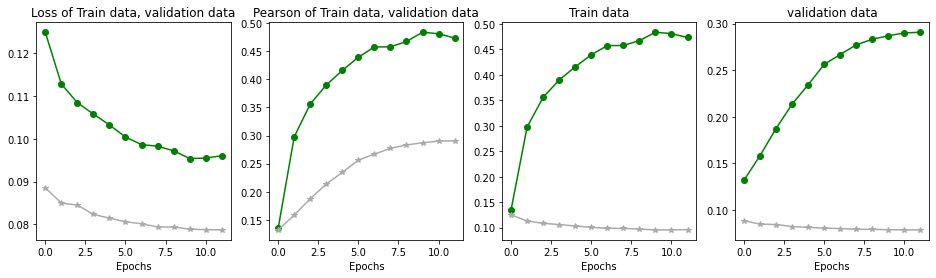

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

## pre-trained 모델 중 일부 freezing ( 11 layer + classifier )

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


In [ ]:
for name, para in model.named_parameters() :
  print(name)

model.embeddings.word_embeddings.weight
model.embeddings.position_embeddings.weight
model.embeddings.token_type_embeddings.weight
model.embeddings.LayerNorm.weight
model.embeddings.LayerNorm.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

for name, para in model.named_parameters() :
  if name.startswith('model.encoder.layer.11') or name.startswith('model.pooler.dense') or name.startswith('classifier.') : 
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

22 181


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.1187, Pearson : 0.3243
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0446, Pearson : 0.8087
Epoch 0 Total Mean Loss : 0.0683
Epoch 0 Total Mean Pearson : 0.6482
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0452 Valid Pearson : 0.7458
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0314, Pearson : 0.8691
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0285, Pearson : 0.8822
Epoch 1 Total Mean Loss : 0.0294
Epoch 1 Total Mean Pearson : 0.8781
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0501 Valid Pearson : 0.7776
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0253, Pearson : 0.8954
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0247, Pearson : 0.8996
Epoch 2 Total Mean L

green is train, gray is validation


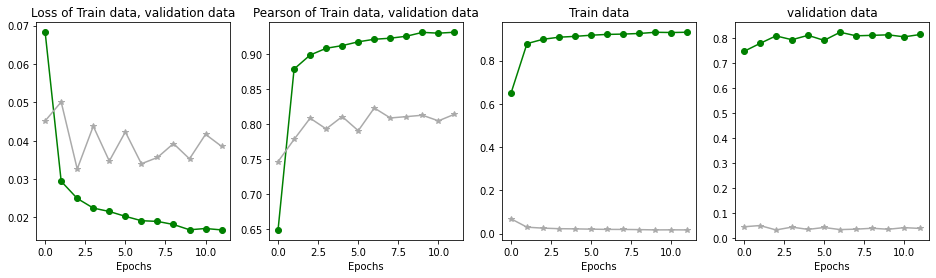

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

## pre-trained 모델 중 일부 freezing ( 6, 7, ... , 11 layer + classifier )

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


In [ ]:
for name, para in model.named_parameters() :
  print(name)

model.embeddings.word_embeddings.weight
model.embeddings.position_embeddings.weight
model.embeddings.token_type_embeddings.weight
model.embeddings.LayerNorm.weight
model.embeddings.LayerNorm.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

for name, para in model.named_parameters() :
  if name.startswith('model.encoder.layer.11') or name.startswith('model.encoder.layer.10') or name.startswith('model.encoder.layer.9') or name.startswith('model.encoder.layer.8') or name.startswith('model.encoder.layer.7') or name.startswith('model.encoder.layer.6') or name.startswith('model.pooler.dense.') or name.startswith('classifier.') :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

102 101


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.0406, Pearson : 0.8034
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0160, Pearson : 0.9382
Epoch 0 Total Mean Loss : 0.0237
Epoch 0 Total Mean Pearson : 0.8939
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0212 Valid Pearson : 0.8647
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0114, Pearson : 0.9554
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0114, Pearson : 0.9569
Epoch 1 Total Mean Loss : 0.0113
Epoch 1 Total Mean Pearson : 0.9567
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0234 Valid Pearson : 0.8790
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0092, Pearson : 0.9644
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0091, Pearson : 0.9638
Epoch 2 Total Mean L

green is train, gray is validation


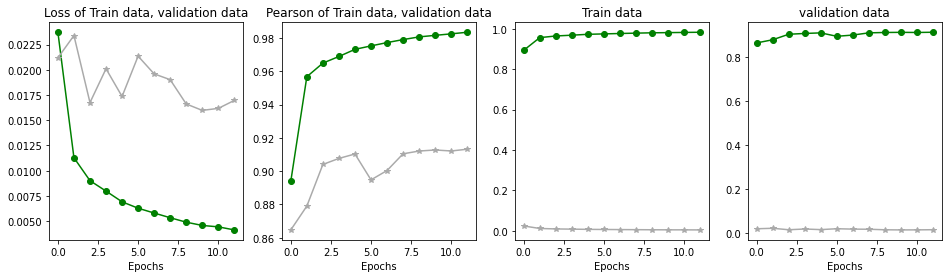

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

# SELU

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'selu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")


*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.0356, Pearson : 0.8509
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0135, Pearson : 0.9533
Epoch 0 Total Mean Loss : 0.0212
Epoch 0 Total Mean Pearson : 0.9178
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0375 Valid Pearson : 0.8715
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0092, Pearson : 0.9694
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0083, Pearson : 0.9711
Epoch 1 Total Mean Loss : 0.0086
Epoch 1 Total Mean Pearson : 0.9701
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0200 Valid Pearson : 0.8972
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0071, Pearson : 0.9746
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0063, Pearson : 0.9774
Epoch 2 Total Mean L

green is train, gray is validation


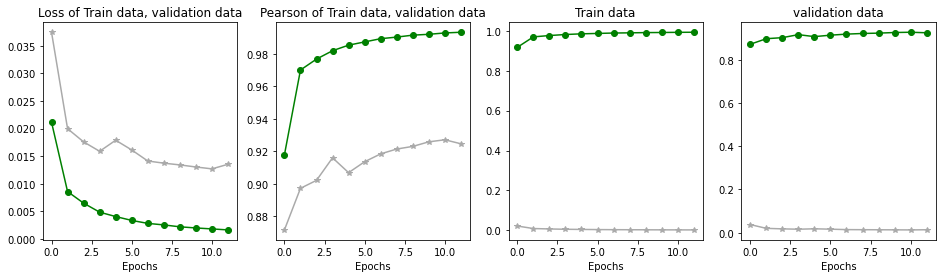

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

In [ ]:
train_dict

{'loss': [0.02116852682339002,
  0.008600307535380125,
  0.0065019465089864925,
  0.004869206837850483,
  0.004075958229575867,
  0.0033755355916458042,
  0.0028386748204492543,
  0.002561294126215914,
  0.002216957252128177,
  0.002010127010895577,
  0.0018367233238029868,
  0.0016556731221100238],
 'pearson': [0.9177888954236899,
  0.9700970741167461,
  0.9768276253791704,
  0.9819878932547896,
  0.9854138111414975,
  0.9874126112624391,
  0.9894042790752567,
  0.9903841048070829,
  0.9915809063062276,
  0.9921054293031561,
  0.9929376510724629,
  0.9933770207509602]}

In [ ]:
valid_dict

{'loss': [0.03745429152074982,
  0.019987377009409314,
  0.017599749762345764,
  0.01589575201711234,
  0.017896557281560758,
  0.016135245123330283,
  0.01413862144245821,
  0.01374361664056778,
  0.013430953710613883,
  0.013052832170882645,
  0.012712713385767797,
  0.013540899490608889],
 'pearson': [0.8715040648684782,
  0.8971545485889211,
  0.9020621671396143,
  0.9159665072665495,
  0.9068001929451438,
  0.9135315838982078,
  0.9183857686379376,
  0.9213658115443062,
  0.9229911951457753,
  0.9258028829798979,
  0.92707658515257,
  0.9246182792326983]}

# Freeze

In [ ]:
model.state_dict().keys()

odict_keys(['model.embeddings.position_ids', 'model.embeddings.word_embeddings.weight', 'model.embeddings.position_embeddings.weight', 'model.embeddings.token_type_embeddings.weight', 'model.embeddings.LayerNorm.weight', 'model.embeddings.LayerNorm.bias', 'model.encoder.layer.0.attention.self.query.weight', 'model.encoder.layer.0.attention.self.query.bias', 'model.encoder.layer.0.attention.self.key.weight', 'model.encoder.layer.0.attention.self.key.bias', 'model.encoder.layer.0.attention.self.value.weight', 'model.encoder.layer.0.attention.self.value.bias', 'model.encoder.layer.0.attention.output.dense.weight', 'model.encoder.layer.0.attention.output.dense.bias', 'model.encoder.layer.0.attention.output.LayerNorm.weight', 'model.encoder.layer.0.attention.output.LayerNorm.bias', 'model.encoder.layer.0.intermediate.dense.weight', 'model.encoder.layer.0.intermediate.dense.bias', 'model.encoder.layer.0.output.dense.weight', 'model.encoder.layer.0.output.dense.bias', 'model.encoder.layer.0.o

In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


## pre-trained 부분 freezing : 12 epoch까지

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'selu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
for para in model.parameters() :
  para.requires_grad = False

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

0 203


In [ ]:
for name, para in model.named_parameters() :
  if name in ['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias'] :
    para.requires_grad = True

true_sum, false_sum = 0, 0

for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

4 199


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.1526, Pearson : 0.0602
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.1226, Pearson : 0.1461
Epoch 0 Total Mean Loss : 0.1323
Epoch 0 Total Mean Pearson : 0.1322
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0861 Valid Pearson : 0.1338
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.1114, Pearson : 0.3120
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.1086, Pearson : 0.3238
Epoch 1 Total Mean Loss : 0.1099
Epoch 1 Total Mean Pearson : 0.3278
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0836 Valid Pearson : 0.1924
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.1060, Pearson : 0.3626
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.1040, Pearson : 0.3962
Epoch 2 Total Mean L

green is train, gray is validation


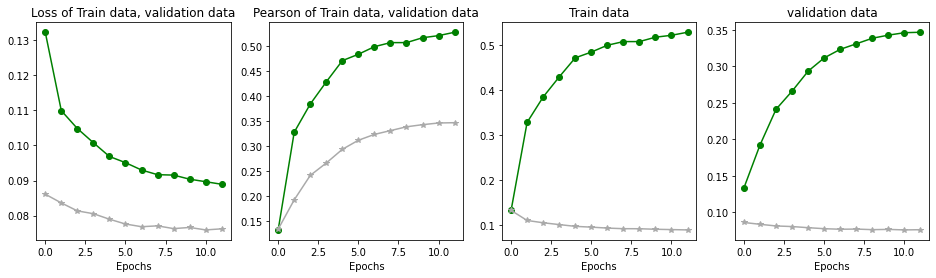

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

## pre-trained 모델 중 일부 freezing ( 11 layer + classifier )

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'selu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


In [ ]:
for name, para in model.named_parameters() :
  print(name)

model.embeddings.word_embeddings.weight
model.embeddings.position_embeddings.weight
model.embeddings.token_type_embeddings.weight
model.embeddings.LayerNorm.weight
model.embeddings.LayerNorm.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

for name, para in model.named_parameters() :
  if name in ['model.encoder.layer.11.attention.self.query.weight', 'model.encoder.layer.11.attention.self.query.bias', 'model.encoder.layer.11.attention.self.key.weight', 'model.encoder.layer.11.attention.self.key.bias', 'model.encoder.layer.11.attention.self.value.weight', 'model.encoder.layer.11.attention.self.value.bias', 'model.encoder.layer.11.attention.output.dense.weight', 'model.encoder.layer.11.attention.output.dense.bias', 'model.encoder.layer.11.attention.output.LayerNorm.weight', 'model.encoder.layer.11.attention.output.LayerNorm.bias', 'model.encoder.layer.11.intermediate.dense.weight', 'model.encoder.layer.11.intermediate.dense.bias', 'model.encoder.layer.11.output.dense.weight', 'model.encoder.layer.11.output.dense.bias', 'model.encoder.layer.11.output.LayerNorm.weight', 'model.encoder.layer.11.output.LayerNorm.bias', 'model.pooler.dense.weight', 'model.pooler.dense.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias'] :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

22 181


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.1062, Pearson : 0.4605
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0448, Pearson : 0.8145
Epoch 0 Total Mean Loss : 0.0640
Epoch 0 Total Mean Pearson : 0.7000
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0420 Valid Pearson : 0.7520
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0311, Pearson : 0.8751
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0273, Pearson : 0.8870
Epoch 1 Total Mean Loss : 0.0285
Epoch 1 Total Mean Pearson : 0.8839
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0670 Valid Pearson : 0.7785
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0266, Pearson : 0.8980
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0244, Pearson : 0.9021
Epoch 2 Total Mean L

green is train, gray is validation


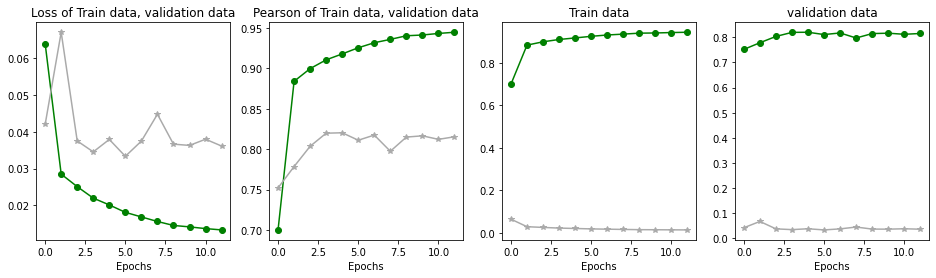

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

## pre-trained 모델 중 일부 freezing ( 6, 7, ... , 11 layer + classifier )

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'selu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


In [ ]:
for name, para in model.named_parameters() :
  print(name)

model.embeddings.word_embeddings.weight
model.embeddings.position_embeddings.weight
model.embeddings.token_type_embeddings.weight
model.embeddings.LayerNorm.weight
model.embeddings.LayerNorm.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

for name, para in model.named_parameters() :
  if name.startswith('model.encoder.layer.11') or name.startswith('model.encoder.layer.10') or name.startswith('model.encoder.layer.9') or name.startswith('model.encoder.layer.8') or name.startswith('model.encoder.layer.7') or name.startswith('model.encoder.layer.6') or name.startswith('model.pooler.dense.') or name.startswith('classifier.') :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

102 101


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.0499, Pearson : 0.7962
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0166, Pearson : 0.9388
Epoch 0 Total Mean Loss : 0.0272
Epoch 0 Total Mean Pearson : 0.8915
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0298 Valid Pearson : 0.8750
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0117, Pearson : 0.9570
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0113, Pearson : 0.9580
Epoch 1 Total Mean Loss : 0.0114
Epoch 1 Total Mean Pearson : 0.9578
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0197 Valid Pearson : 0.8867
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0086, Pearson : 0.9671
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0083, Pearson : 0.9684
Epoch 2 Total Mean L

green is train, gray is validation


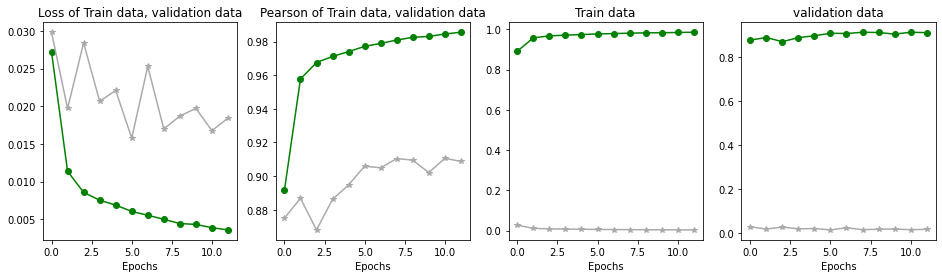

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

# GELU

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 10, model_name, learning_rate, weight_decay, 'gelu')


Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 10 epochs: 3650
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 10


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 10, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")


*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000482329, Avg Loss : 0.0330, Pearson : 0.8453
Epoch: 0, Step : 256, LR : 0.0000464795, Avg Loss : 0.0110, Pearson : 0.9584
Epoch 0 Total Mean Loss : 0.0186
Epoch 0 Total Mean Pearson : 0.9198
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0167 Valid Pearson : 0.9042
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000432329, Avg Loss : 0.0074, Pearson : 0.9717
Epoch: 1, Step : 256, LR : 0.0000414795, Avg Loss : 0.0074, Pearson : 0.9714
Epoch 1 Total Mean Loss : 0.0074
Epoch 1 Total Mean Pearson : 0.9716
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0179 Valid Pearson : 0.9088
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000382329, Avg Loss : 0.0059, Pearson : 0.9783
Epoch: 2, Step : 256, LR : 0.0000364795, Avg Loss : 0.0055, Pearson : 0.9793
Epoch 2 Total Mean L

green is train, gray is validation


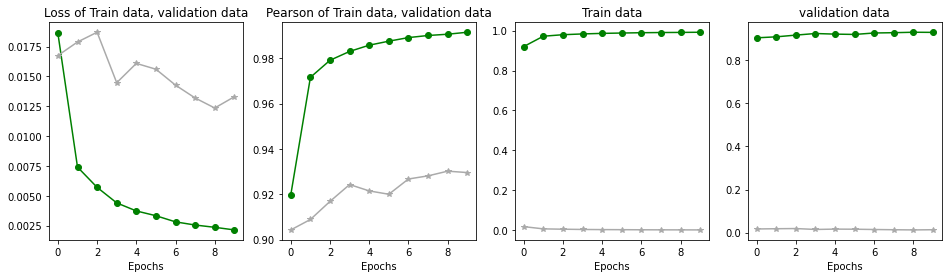

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

In [ ]:
train_dict

{'loss': [0.018604387989752506,
  0.007398228336457317,
  0.005700614290592605,
  0.00439762175115055,
  0.00372405605668151,
  0.0033234433652131424,
  0.002808354194084667,
  0.002544075326215833,
  0.0023528696447674643,
  0.0021344585819425034],
 'pearson': [0.9197567723181149,
  0.9715744988559044,
  0.9791057393975454,
  0.9830087377600474,
  0.9857669911972464,
  0.9875318189189859,
  0.9891152808111008,
  0.9900413392341301,
  0.9906015054820335,
  0.9914753210054685]}

In [ ]:
valid_dict

{'loss': [0.016743490116342026,
  0.017876727725653088,
  0.018694412511061218,
  0.014465646270443411,
  0.016084325006779504,
  0.015597002361627185,
  0.014261968926910092,
  0.013186866198392475,
  0.012347449658109862,
  0.013291402281645466],
 'pearson': [0.9042371616644018,
  0.9088432613541099,
  0.9168309569358826,
  0.9242604024270001,
  0.9214523539823645,
  0.9199743025443133,
  0.9267118643311893,
  0.9280917574377621,
  0.9301657992250779,
  0.9295505986494177]}

# Freeze

In [ ]:
model.state_dict().keys()

odict_keys(['model.embeddings.position_ids', 'model.embeddings.word_embeddings.weight', 'model.embeddings.position_embeddings.weight', 'model.embeddings.token_type_embeddings.weight', 'model.embeddings.LayerNorm.weight', 'model.embeddings.LayerNorm.bias', 'model.encoder.layer.0.attention.self.query.weight', 'model.encoder.layer.0.attention.self.query.bias', 'model.encoder.layer.0.attention.self.key.weight', 'model.encoder.layer.0.attention.self.key.bias', 'model.encoder.layer.0.attention.self.value.weight', 'model.encoder.layer.0.attention.self.value.bias', 'model.encoder.layer.0.attention.output.dense.weight', 'model.encoder.layer.0.attention.output.dense.bias', 'model.encoder.layer.0.attention.output.LayerNorm.weight', 'model.encoder.layer.0.attention.output.LayerNorm.bias', 'model.encoder.layer.0.intermediate.dense.weight', 'model.encoder.layer.0.intermediate.dense.bias', 'model.encoder.layer.0.output.dense.weight', 'model.encoder.layer.0.output.dense.bias', 'model.encoder.layer.0.o

In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


## pre-trained 부분 freezing : 12 epoch까지

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'gelu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
for para in model.parameters() :
  para.requires_grad = False

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

0 203


In [ ]:
for name, para in model.named_parameters() :
  if name in ['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias'] :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

4 199


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.1497, Pearson : -0.0323
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.1224, Pearson : 0.0737
Epoch 0 Total Mean Loss : 0.1317
Epoch 0 Total Mean Pearson : 0.0527
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0897 Valid Pearson : 0.0991
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.1182, Pearson : 0.1836
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.1170, Pearson : 0.2398
Epoch 1 Total Mean Loss : 0.1164
Epoch 1 Total Mean Pearson : 0.2319
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0867 Valid Pearson : 0.1321
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.1119, Pearson : 0.3066
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.1115, Pearson : 0.3202
Epoch 2 Total Mean 

green is train, gray is validation


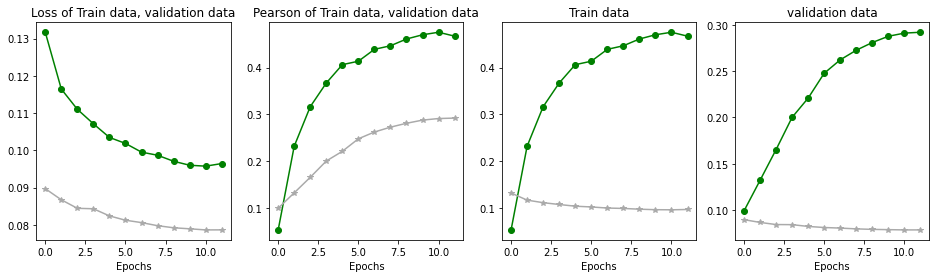

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

## pre-trained 모델 중 일부 freezing ( 11 layer + classifier )

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'gelu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


In [ ]:
for name, para in model.named_parameters() :
  print(name)

model.embeddings.word_embeddings.weight
model.embeddings.position_embeddings.weight
model.embeddings.token_type_embeddings.weight
model.embeddings.LayerNorm.weight
model.embeddings.LayerNorm.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

for name, para in model.named_parameters() :
  if name in ['model.encoder.layer.11.attention.self.query.weight', 'model.encoder.layer.11.attention.self.query.bias', 'model.encoder.layer.11.attention.self.key.weight', 'model.encoder.layer.11.attention.self.key.bias', 'model.encoder.layer.11.attention.self.value.weight', 'model.encoder.layer.11.attention.self.value.bias', 'model.encoder.layer.11.attention.output.dense.weight', 'model.encoder.layer.11.attention.output.dense.bias', 'model.encoder.layer.11.attention.output.LayerNorm.weight', 'model.encoder.layer.11.attention.output.LayerNorm.bias', 'model.encoder.layer.11.intermediate.dense.weight', 'model.encoder.layer.11.intermediate.dense.bias', 'model.encoder.layer.11.output.dense.weight', 'model.encoder.layer.11.output.dense.bias', 'model.encoder.layer.11.output.LayerNorm.weight', 'model.encoder.layer.11.output.LayerNorm.bias', 'model.pooler.dense.weight', 'model.pooler.dense.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias'] :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

22 181


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.0986, Pearson : 0.4506
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0414, Pearson : 0.8251
Epoch 0 Total Mean Loss : 0.0592
Epoch 0 Total Mean Pearson : 0.7033
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0447 Valid Pearson : 0.7591
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0285, Pearson : 0.8825
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0243, Pearson : 0.9001
Epoch 1 Total Mean Loss : 0.0253
Epoch 1 Total Mean Pearson : 0.8954
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0476 Valid Pearson : 0.7930
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0200, Pearson : 0.9188
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0204, Pearson : 0.9177
Epoch 2 Total Mean L

green is train, gray is validation


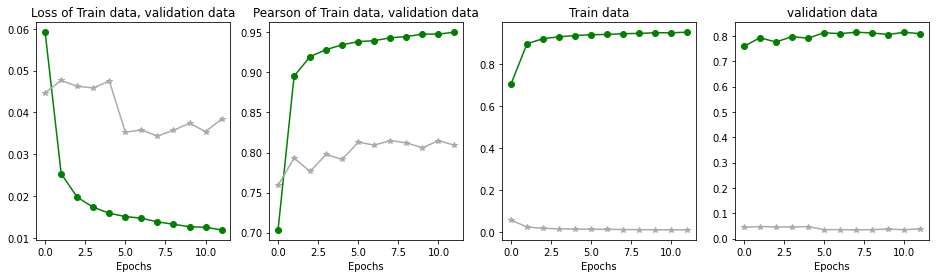

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)

## pre-trained 모델 중 일부 freezing ( 6, 7, ... , 11 layer + classifier )

In [ ]:
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 12, model_name, learning_rate, weight_decay, 'gelu')

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 12 epochs: 4380
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 12


In [ ]:
true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

203 0


In [ ]:
for name, para in model.named_parameters() :
  print(name)

model.embeddings.word_embeddings.weight
model.embeddings.position_embeddings.weight
model.embeddings.token_type_embeddings.weight
model.embeddings.LayerNorm.weight
model.embeddings.LayerNorm.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self

In [ ]:
for para in model.parameters() :
  para.requires_grad = False

for name, para in model.named_parameters() :
  if name.startswith('model.encoder.layer.11') or name.startswith('model.encoder.layer.10') or name.startswith('model.encoder.layer.9') or name.startswith('model.encoder.layer.8') or name.startswith('model.encoder.layer.7') or name.startswith('model.encoder.layer.6') or name.startswith('model.pooler.dense.') or name.startswith('classifier.') :
    para.requires_grad = True

true_sum, false_sum = 0, 0
for para in model.parameters() :
  if para.requires_grad == True :
    true_sum += 1
  else :
    false_sum += 1
print(true_sum, false_sum)

102 101


In [ ]:
start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 12, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000485274, Avg Loss : 0.0406, Pearson : 0.8158
Epoch: 0, Step : 256, LR : 0.0000470662, Avg Loss : 0.0141, Pearson : 0.9476
Epoch 0 Total Mean Loss : 0.0232
Epoch 0 Total Mean Pearson : 0.9017
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.0354 Valid Pearson : 0.8488
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000443607, Avg Loss : 0.0113, Pearson : 0.9585
Epoch: 1, Step : 256, LR : 0.0000428995, Avg Loss : 0.0100, Pearson : 0.9617
Epoch 1 Total Mean Loss : 0.0104
Epoch 1 Total Mean Pearson : 0.9604
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.0292 Valid Pearson : 0.8809
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000401941, Avg Loss : 0.0088, Pearson : 0.9669
Epoch: 2, Step : 256, LR : 0.0000387329, Avg Loss : 0.0091, Pearson : 0.9651
Epoch 2 Total Mean L

green is train, gray is validation


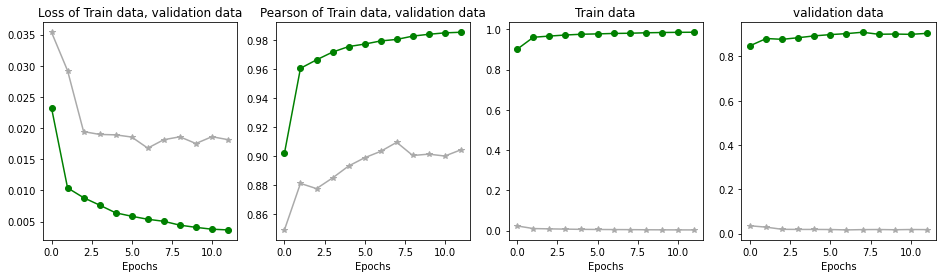

<Figure size 432x288 with 0 Axes>

In [ ]:
draw_plot(train_dict, valid_dict, 0)